8/10/21

Unifying the PI soiling analysis to use a single SD formulation. Shows testing on synthetic and real data.

In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
from model_soiling import generate_my_soiling_signals

import pandas as pd
import cvxpy as cvx
from scipy.signal import find_peaks
from scipy.stats import mode, pearsonr
from sklearn.metrics import r2_score
from glob import glob
from time import time
from pathlib import Path

from solardatatools import DataHandler
from solardatatools.algorithms import soiling_seperation
# from solardatatools.algorithms.soiling import soiling_seperation_v2
from solardatatools.utilities import progress
from solardatatools.algorithms.soiling import DEFAULT

In [96]:
# %matplotlib notebook
%matplotlib inline

In [97]:
SAVE = False

# SAVE = True

if SAVE:
    import matplotlib
#     sns.set_context('notebook')
    matplotlib.rcParams['axes.unicode_minus'] = False
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

In [4]:
fn = '/Users/bennetmeyers/Documents/PVInsight/phase_1/algorithms_dev/soiling/total_data/unified_data.csv'
if not Path(fn).is_file():
    files = glob('total_data/total_p*.csv')
    files.sort()
    total_dfs = [pd.read_csv(f, index_col=0, parse_dates=[0]) for f in files]
    df = pd.concat(total_dfs)
    df.to_csv(fn)
else:
    df = pd.read_csv(fn, index_col=0, parse_dates=True)

dh1 = DataHandler(df, aggregate='5min')
dh2 = DataHandler(df, aggregate='5min')

dh1.run_pipeline(power_col=df.columns[1], fix_shifts=False, correct_tz=False)
dh2.run_pipeline(power_col=df.columns[2], fix_shifts=False, correct_tz=False)

e1 = np.sum(dh1.filled_data_matrix, axis=0)
e2 = np.sum(dh2.filled_data_matrix, axis=0)
soiling_PI = e1/e2
soiling_PI[soiling_PI > 1.5] = np.nan

total time: 7.10 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              1.29s
Cleaning                   0.11s
Filtering/Summarizing      5.70s
    Data quality           0.13s
    Clear day detect       0.13s
    Clipping detect        4.93s
    Capacity change detect 0.52s

total time: 7.44 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              2.08s
Cleaning                   0.10s
Filtering/Summarizing      5.26s
    Data quality           0.13s
    Clear day detect       0.13s
    Clipping detect        4.50s
    Capacity change detect 0.50s



/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


In [5]:
dh1.report()

Length:                1.75 years
Capacity estimate:     1.24 kW
Data sampling:         5 minute
Data quality score:    98.3%
Data clearness score:  63.0%
Inverter clipping:     False
Time shifts corrected: None
Time zone correction:  None


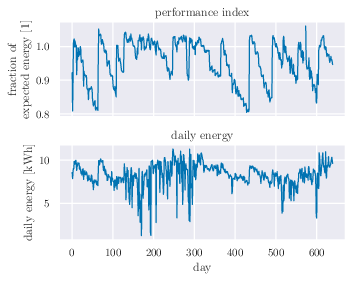

In [195]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(5,4))
ax[0].plot(soiling_PI, linewidth=1);
ax[1].plot(e1 * 5 / 60/1000, linewidth=1);
ax[0].set_title('performance index')
ax[1].set_title('daily energy')
ax[0].set_ylabel('fraction of\nexpected energy [1]')
ax[1].set_ylabel('daily energy [kWh]')
ax[1].set_xlabel('day')
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('figs/pv-data.pgf')

In [176]:
soiling_signal = soiling_PI

# config = {
#     'degradation_term': False, 
#     'tau': 0.85, 
#     'iterations': 5, 
#     'w1': 0.5, 
#     'w2': 1e-2,
#     'w3': 1e-2,
#     'w4': 1e3,
# }
params = DEFAULT.copy()
params['iterations'] = 3
params['tau'] = 0.5
params['w2'] /= 5

out_soiling_PI = soiling_seperation(
    soiling_signal, **params
)

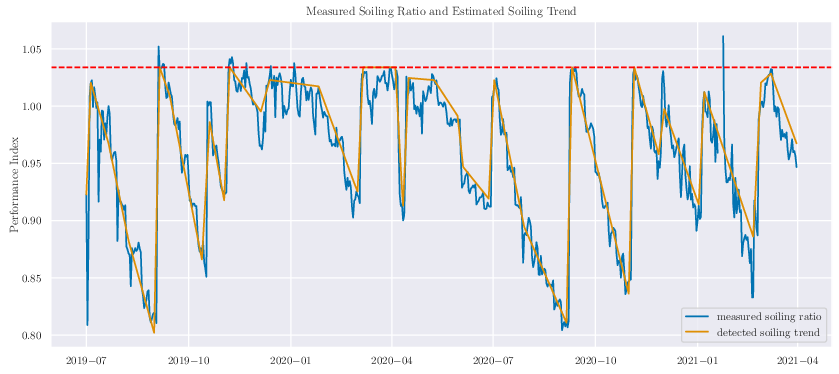

In [177]:
plt.figure(figsize=(14, 6))
xs = dh1.day_index
plt.plot(xs, soiling_PI, label='measured soiling ratio')
plt.plot(xs, out_soiling_PI['soiling']+np.nanquantile(soiling_PI, .98), label='detected soiling trend')
plt.ylabel('Performance Index')
plt.title('Measured Soiling Ratio and Estimated Soiling Trend')
shift = np.nanquantile(soiling_PI, .98)
plt.axhline(shift, ls='--', color='red')
plt.legend();

In [178]:
soiling_signal = e1 / np.nanquantile(e1, .95)
# config = {
#     'degradation_term': True, 
#     'tau': 0.85, 
#     'iterations': 5, 
#     'w1': 1.5, 
#     'w2': 2e-2,
#     'w3': 1e-1,
#     'w4': 5e2
# }
params = DEFAULT.copy()
params['iterations'] = 3
# params['tau'] = 0.5
params['w2'] /= 5
out_energy = soiling_seperation(
    soiling_signal, **config
)

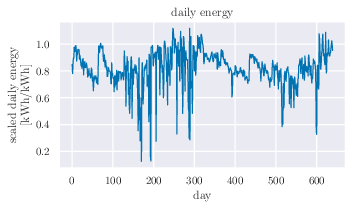

In [179]:
fig = plt.figure(figsize=(5, 3))
ax = plt.gca()
ax.plot(e1 / np.nanquantile(e1, .95), linewidth=1)
ax.set_title('daily energy')
ax.set_ylabel('scaled daily energy\n[kWh/kWh]')
ax.set_xlabel('day')
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('figs/energy.pgf')

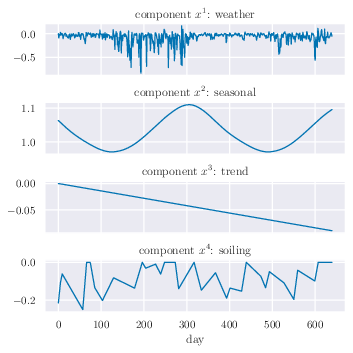

In [180]:
fig, ax = plt.subplots(nrows=4, figsize=(5, 5), sharex=True)
ax[0].plot(out_energy['residual'], linewidth=1)
ax[1].plot(out_energy['seasonal'], linewidth=1)
ax[2].plot(out_energy['trend'], linewidth=1)
ax[3].plot(out_energy['soiling'], linewidth=1)
ax[3].set_xlabel('day')
labels = ['weather', 'seasonal', 'trend', 'soiling']
for ix in range(4):
    ax[ix].set_title('component $x^{' + '{}'.format(ix+1) + '}$:  ' + labels[ix])
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('figs/energy-decomposed.pgf')

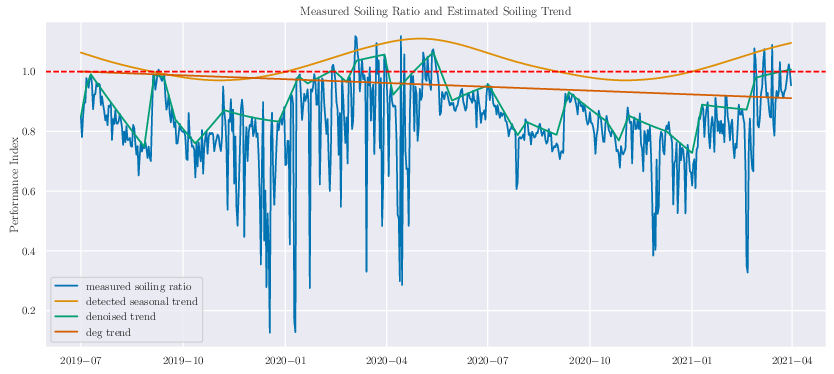

In [181]:
plt.figure(figsize=(14, 6))
xs = dh1.day_index
plt.plot(xs, soiling_signal, label='measured soiling ratio')
plt.plot(xs, out_energy['seasonal'], label='detected seasonal trend')
plt.plot(xs, out_energy['soiling'] + out_energy['seasonal'] + out_energy['trend'], label='denoised trend')
plt.plot(xs, out_energy['trend'] + 1, label='deg trend')
plt.ylabel('Performance Index')
plt.title('Measured Soiling Ratio and Estimated Soiling Trend')
plt.axhline(1, ls='--', color='red')
plt.legend();

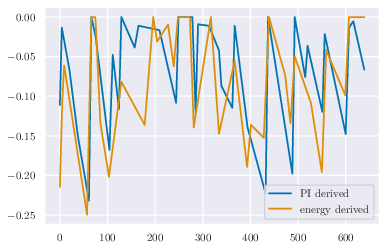

In [182]:
plt.plot(out_soiling_PI['soiling'], label='PI derived')
plt.plot(out_energy['soiling'], label='energy derived')
plt.legend()

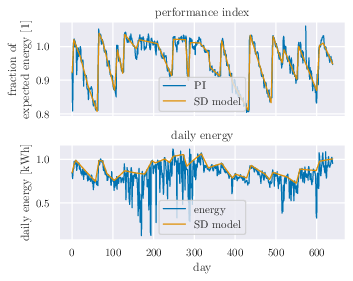

In [184]:
PI_model = out_soiling_PI['denoised']
energy_model = out_energy['denoised']

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(5,4))
ax[0].plot(soiling_PI, linewidth=1);
ax[1].plot(soiling_signal, linewidth=1);
ax[0].plot(PI_model, linewidth=1)
ax[1].plot(energy_model, linewidth=1)
ax[0].set_title('performance index')
ax[1].set_title('daily energy')
ax[0].set_ylabel('fraction of\nexpected energy [1]')
ax[1].set_ylabel('daily energy [kWh]')
ax[1].set_xlabel('day')
ax[0].legend(['PI', 'SD model'])
ax[1].legend(['energy', 'SD model'])
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('figs/pv-data-after-SD.pgf')

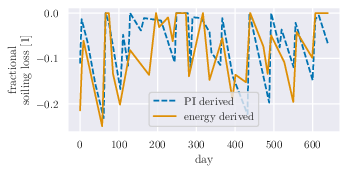

In [189]:
plt.figure(figsize=(5,2.5))
plt.plot(out_soiling_PI['soiling'], label='PI derived', ls='--')
plt.plot(out_energy['soiling'], label='energy derived')
# plt.title('soiling loss estimates')
plt.ylabel('fractional\nsoiling loss [1]')
plt.legend()
plt.xlabel('day')
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('figs/labeled-soiling-loss.pgf')

In [192]:
rmse = lambda x: np.sqrt(np.mean(np.power(x, 2)))
mae = lambda x: np.mean(np.abs(x))
residual = (out_soiling_PI['soiling']) - out_energy['soiling']
diff_residual = np.diff(out_soiling_PI['soiling']) - np.diff(out_energy['soiling'])
slct = np.logical_and(
    np.diff(out_soiling_PI['soiling']) <= 0,
    np.diff(out_energy['soiling']) <= 0
)
errors = pd.DataFrame(columns=['loss_r', 'rate_r', 'soil_rate_r'],
                 index=['rmse', 'mae'],
                 data=[[rmse(residual), rmse(diff_residual), rmse(diff_residual[slct])],
                       [mae(residual), mae(diff_residual), mae(diff_residual[slct])]])

In [193]:
errors

loss_r    rate_r  soil_rate_r
rmse  0.051418  0.007903     0.002469
mae   0.042558  0.004734     0.001756

In [91]:
np.random.seed(42)
dfs, names = generate_my_soiling_signals()

In [92]:
names

['normal',
 'M Soil, H season',
 'M Soil, H noise',
 'Seasonal cleaning',
 'L/M Soil (.0005)',
 'Low Soil (.0001)']

/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


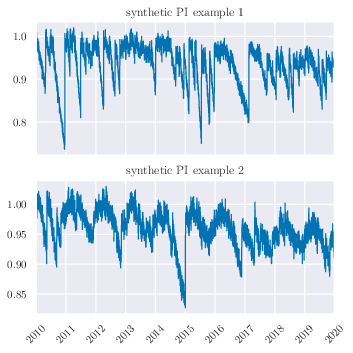

In [99]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(5, 5))
for i in range(2):
    dfs[i].plot(y='daily_norm', ax=axes[i], linewidth=1, legend=False)
    axes[i].set_title('synthetic PI example {}'.format(i+1))
plt.xticks(rotation=45) 
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('figs/synth-soil.pgf')
plt.show()

In [100]:
ti = time()

params = DEFAULT.copy()
params['iterations'] = 3
params['tau'] = 0.5
params['w2'] /= 5
results = []
for i in range(2):
    soiling_signal = dfs[i]['daily_norm'].values
    out = soiling_seperation(
        soiling_signal, verbose=False, **params
    )
    results.append(out)
tf = time()
print('that took {:.1f} seconds'.format(tf - ti))

that took 39.8 seconds


/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


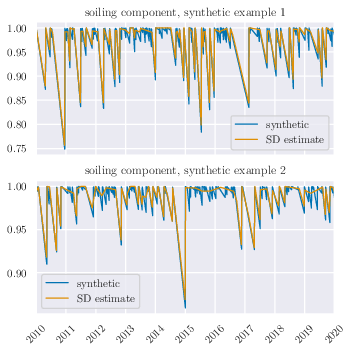

In [103]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(5, 5))
for i in range(2):
    dfs[i].plot(y='soiling', ax=ax[i], linewidth=1, legend=False)
    ax[i].plot(dfs[i].index, results[i]['soiling'] + 1, linewidth=1)
    ax[i].legend(['synthetic', 'SD estimate'])
    ax[i].set_title('soiling component, synthetic example {}'.format(i+1))
plt.xticks(rotation=45) 
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('figs/synth-results.pgf')
plt.show()

In [104]:
def analyze_result(synthetic_data, plot_data=False, **params):
    df = synthetic_data
    rmse = lambda x: np.sqrt(np.mean(np.power(x, 2)))
    mae = lambda x: np.mean(np.abs(x))
    soiling_signal = df['daily_norm'].values
    sd = soiling_seperation(
        soiling_signal, verbose=False, **params
    )
    residual = (df['soiling'].values - 1) - sd['soiling']
    diff_residual = np.diff(df['soiling'].values - 1) - np.diff(sd['soiling'])
    slct = np.logical_and(
        np.diff(df['soiling'].values - 1) <= 0,
        np.diff(sd['soiling']) <= 0
    )
    errors = pd.DataFrame(columns=['loss_r', 'rate_r', 'soil_rate_r'],
                     index=['rmse', 'mae'],
                     data=[[rmse(residual), rmse(diff_residual), rmse(diff_residual[slct])],
                           [mae(residual), mae(diff_residual), mae(diff_residual[slct])]])
    if plot_data:
        fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(5, 5))
        df.plot(y='daily_norm', ax=ax[0], ls='', marker='.', ms=1)
        ax[0].plot(df.index, sd['soiling'] + sd['seasonal'] + sd['trend'])
        ax[1].plot(df.index, df['soiling'].values-1)
        ax[1].plot(df.index, sd['soiling'])
        plt.show()
    return errors

In [105]:
analyze_result(dfs[0])

loss_r    rate_r  soil_rate_r
rmse  0.015448  0.010478     0.000691
mae   0.008698  0.002257     0.000379

In [106]:
analyze_result(dfs[1])

loss_r    rate_r  soil_rate_r
rmse  0.008038  0.004358     0.000291
mae   0.005366  0.000919     0.000202

In [141]:
i = 5
diffs = np.diff(dfs[i]['soiling'])
diffs = diffs[diffs <= 0]
print(np.median(diffs), np.mean(diffs))

-5.355774040172179e-05 -5.061892421593106e-05


In [149]:
study_results = pd.read_csv('data/synthetic_soiling_study_10yr_20220524.csv', index_col=0)
study_results.loc[study_results['name'] == 'M Soil, H season', 'name'] = 'M soil, H season'
study_results.loc[study_results['name'] == 'M Soil, H noise', 'name'] = 'M soil, H noise'
study_results.loc[study_results['name'] == 'Seasonal cleaning', 'name'] = 'seasonal cleaning'
study_results.loc[study_results['name'] == 'L/M Soil (.0005)', 'name'] = 'M soil'
study_results.loc[study_results['name'] == 'Low Soil (.0001)', 'name'] = 'L soil'
study_results

run               name     mae-r     mae-d    mae-sr    rmse-r    rmse-d  \
0     0             normal  0.007033  0.002494  0.000356  0.011850  0.012368   
1     0   M soil, H season  0.004365  0.000919  0.000283  0.006130  0.004079   
2     0    M soil, H noise  0.005139  0.000949  0.000286  0.007097  0.003832   
3     0  seasonal cleaning  0.004991  0.000871  0.000213  0.006528  0.004195   
4     0             M soil  0.003768  0.000513  0.000209  0.005236  0.002113   
5     0             L soil  0.001360  0.000110  0.000053  0.001934  0.000528   
6     1             normal  0.005901  0.002726  0.000355  0.010733  0.012117   
7     1   M soil, H season  0.003683  0.000931  0.000231  0.005465  0.004074   
8     1    M soil, H noise  0.007005  0.001013  0.000353  0.009505  0.004139   
9     1  seasonal cleaning  0.006489  0.000866  0.000215  0.008142  0.004560   
10    1             M soil  0.003453  0.000505  0.000163  0.004767  0.002297   
11    1             L soil  0.001072  0.000093  0.000045  0.001560  0.000405   
12    2             normal  0.006397  0.002615  0.000392  0.011045  0.012216   
13    2   M soil, H season  0.004198  0.001006  0.000221  0.006118  0.004716   
14    2    M soil, H noise  0.005023  0.000907  0.000260  0.007067  0.004166   
15    2  seasonal cleaning  0.005633  0.000886  0.000187  0.007319  0.004780   
16    2             M soil  0.003472  0.000510  0.000130  0.004789  0.002491   
17    2             L soil  0.001069  0.000090  0.000044  0.001543  0.000420   
18    3             normal  0.006551  0.002481  0.000408  0.011407  0.012361   
19    3   M soil, H season  0.004086  0.000899  0.000228  0.005846  0.004065   
20    3    M soil, H noise  0.005310  0.000996  0.000312  0.007524  0.004362   
21    3  seasonal cleaning  0.005227  0.000888  0.000191  0.006800  0.004573   
22    3             M soil  0.002727  0.000413  0.000127  0.004048  0.002026   
23    3             L soil  0.001062  0.000089  0.000036  0.001375  0.000399   
24    4             normal  0.007325  0.002724  0.000378  0.011318  0.011738   
25    4   M soil, H season  0.003661  0.000898  0.000174  0.005784  0.004357   
26    4    M soil, H noise  0.005539  0.001006  0.000279  0.007831  0.004835   
27    4  seasonal cleaning  0.005370  0.000885  0.000228  0.007108  0.004123   
28    4             M soil  0.002890  0.000441  0.000144  0.004261  0.002074   
29    4             L soil  0.001219  0.000092  0.000047  0.001879  0.000443   
30    5             normal  0.006287  0.002518  0.000403  0.010492  0.011036   
31    5   M soil, H season  0.004643  0.000927  0.000304  0.006407  0.004111   
32    5    M soil, H noise  0.005255  0.001016  0.000278  0.007494  0.004206   
33    5  seasonal cleaning  0.005361  0.000905  0.000192  0.007046  0.004245   
34    5             M soil  0.003046  0.000435  0.000163  0.004272  0.001932   
35    5             L soil  0.000979  0.000092  0.000042  0.001420  0.000406   
36    6             normal  0.006825  0.002358  0.000377  0.012127  0.013395   
37    6   M soil, H season  0.004329  0.000974  0.000184  0.006376  0.004517   
38    6    M soil, H noise  0.006344  0.001035  0.000315  0.008697  0.004314   
39    6  seasonal cleaning  0.004947  0.000886  0.000229  0.006646  0.004215   
40    6             M soil  0.003121  0.000446  0.000162  0.004194  0.001924   
41    6             L soil  0.000976  0.000086  0.000042  0.001409  0.000406   
42    7             normal  0.007284  0.002538  0.000397  0.012391  0.013329   
43    7   M soil, H season  0.003909  0.000959  0.000264  0.005727  0.004304   
44    7    M soil, H noise  0.005211  0.001000  0.000270  0.007340  0.004487   
45    7  seasonal cleaning  0.005182  0.000888  0.000207  0.006883  0.004315   
46    7             M soil  0.002861  0.000421  0.000156  0.004197  0.001791   
47    7             L soil  0.001240  0.000105  0.000046  0.001765  0.000485   
48    8             normal  0.007146  0.002514  0.000409  0.011088  0.011156   
49  

In [154]:
sns.displot?

/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  """


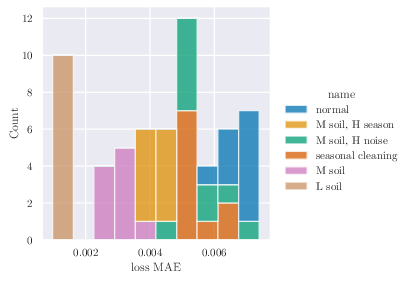

In [166]:
sns.displot(study_results, x='mae-r', hue='name', bins=10, multiple='stack', height=4)
plt.xlabel('loss MAE')
if SAVE:
    plt.gcf().savefig('figs/synth-loss-mae.pgf')
plt.show()

/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  """


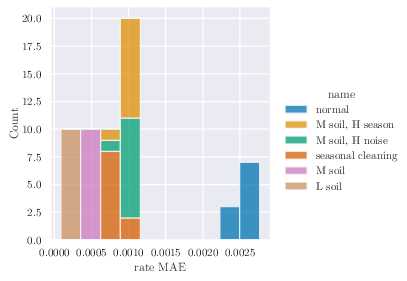

In [164]:
sns.displot(study_results, x='mae-d', hue='name', bins=10, multiple='stack', height=4)
plt.xlabel('rate MAE')
if SAVE:
    plt.gcf().savefig('figs/synth-rate-mae.pgf')
plt.show()

/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  """


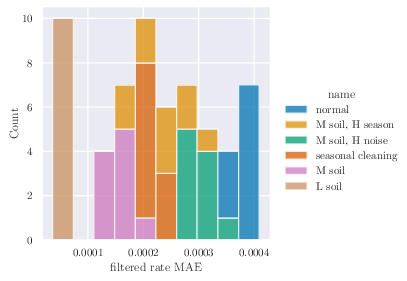

In [165]:
sns.displot(study_results, x='mae-sr', hue='name', bins=10, multiple='stack', height=4)
plt.xlabel('filtered rate MAE')
if SAVE:
    plt.gcf().savefig('figs/synth-frate-mae.pgf')
plt.show()

In [25]:
residual = dfs[i]['soiling'].values-1- s1d
np.mean(np.abs(residual))

0.005020907464264909

In [26]:
pks, _ = find_peaks(-1 * (dfs[i]['soiling'].values - 1))
trghs, _ = find_peaks(dfs[i]['soiling'].values - 1)
trghs = np.concatenate([[0], trghs])
event_report = pd.DataFrame(columns=[
    'start', 'end', 'peak', 'loss', 'rate', 'est peak', 'est loss', 'est rate'
])
event_report['start'] = trghs[:-1]
event_report['end'] = trghs[1:]
event_report['peak'] = (dfs[i]['soiling'].values-1)[pks]
for j in range(len(event_report)):
    slce = np.s_[event_report.loc[j]['start']: event_report.loc[j]['end']]
    actual_loss = np.sum((dfs[i]['soiling'].values - 1)[slce])
    estimated_loss = np.sum(s1d[slce])
    estimated_peak = np.min(s1d[slce])
    actual_rates = np.diff((dfs[i]['soiling'].values - 1)[slce])
    actual_rates = actual_rates[actual_rates <= 0]
    actual_rate = mode(actual_rates)[0][0]
    estimated_rates = np.diff(s1d[slce])
    estimated_rates = estimated_rates[estimated_rates <= 0]
    try:
        estimated_rate = mode(estimated_rates)[0][0]
    except IndexError:
        estimated_rate = 0
    event_report.loc[j, ['loss', 'rate', 'est peak', 'est loss', 'est rate']] = [
        actual_loss, actual_rate, estimated_peak, estimated_loss, estimated_rate
    ]

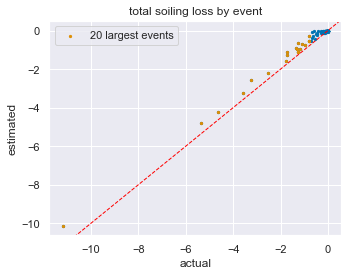

In [27]:
plt.figure(figsize=(5, 4))
slct = np.abs(np.asarray(event_report['loss'].values, dtype=float)) >= .75
plt.scatter(event_report['loss'], event_report['est loss'], s=5)
plt.scatter(event_report['loss'][slct], event_report['est loss'][slct], s=5, label='20 largest events')
plt.legend()
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='red', lw=1, scalex=False, scaley=False)
plt.ylabel('estimated')
plt.xlabel('actual')
plt.title('total soiling loss by event')
plt.tight_layout()
plt.show();
if SAVE:
    plt.gcf().savefig('figs/synthetic-loss.pgf')

20 110


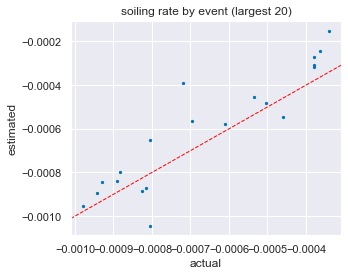

In [28]:
plt.figure(figsize=(5, 4))
# plt.scatter(event_report['rate'], event_report['est rate'],
#             s=10*np.abs(np.asarray(event_report['loss'].values, dtype=float)))
slct = np.abs(np.asarray(event_report['loss'].values, dtype=float)) >= .75
plt.scatter(event_report['rate'][slct], event_report['est rate'][slct], s=5)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='red', lw=1, scalex=False, scaley=False)
plt.ylabel('estimated')
plt.xlabel('actual')
plt.title('soiling rate by event (largest 20)')
plt.tight_layout()
print(np.sum(slct), len(slct))
plt.tight_layout()
plt.show()
if SAVE:
    plt.gcf().savefig('figs/synthetic-rate.pgf')

In [44]:
event_losses = np.asarray(event_report['loss'].values,dtype=float)

(array([ 1.,  4., 10.,  8., 27., 19., 14., 18.,  6.,  3.]),
 array([-3.43293313, -2.9847582 , -2.53658326, -2.08840833, -1.6402334 ,
        -1.19205847, -0.74388354, -0.29570861,  0.15246633,  0.60064126,
         1.04881619]),
 <BarContainer object of 10 artists>)

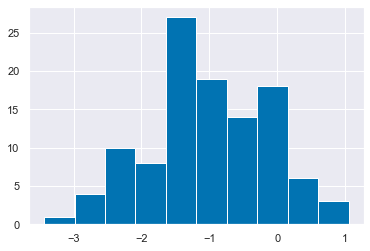

In [45]:
plt.hist(np.log10(np.abs(event_losses)))

In [35]:
r2_score(event_report['rate'][slct], event_report['est rate'][slct])

0.6692801846755305

In [36]:
r2_score(event_report['loss'][slct], event_report['est loss'][slct])

0.9613598787621707

In [31]:
pearsonr(event_report['rate'][slct], event_report['est rate'][slct])

(0.9095718219060916, 2.755274554301928e-08)

## Synthetic data example 1

<AxesSubplot:>

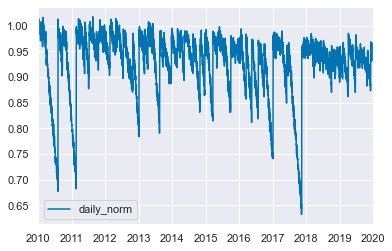

In [6]:
data = dfs[0]
data.plot(y='daily_norm')

In [7]:
soiling_signal = data['daily_norm'].values

config = {
    'degradation_term': True, 
    'tau': 0.85, 
    'iterations': 3, 
    'w1': 0.5, 
    'w2': 8e-2,
    'w3': 1e-2,
    'w4': 1e3
}
ti = time()
s1d, s2d, s3d, srd = soiling_seperation(
    soiling_signal, verbose=True, **config
)
tf = time()
print('that took {:.1f} seconds'.format(tf - ti))

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) May 18 04:37:25 PM: Your problem has 14612 variables, 5 constraints, and 3651 parameters.
(CVXPY) May 18 04:37:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 18 04:37:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 18 04:37:25 PM: Compiling problem (target solver=MOSEK).
(CVXPY) May 18 04:37:25 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) May 18 04:37:25 PM: Applying reduction Dcp2Cone
(CVXPY) May 18 04:37:25 PM: Applying reduction CvxAttr2Constr


(CVXPY) May 18 04:37:43 PM: 23  2.7e-02  1.1e-04  3.1e-05  9.98e-01   2.055780159e+01   2.056370852e+01   2.7e-05  0.43  
(CVXPY) May 18 04:37:43 PM: 24  2.7e-02  1.1e-04  3.2e-05  7.87e-01   2.055825273e+01   2.056428088e+01   2.7e-05  0.45  
(CVXPY) May 18 04:37:43 PM: 25  2.7e-02  1.1e-04  3.2e-05  4.36e-01   2.055890408e+01   2.056504943e+01   2.7e-05  0.46  
(CVXPY) May 18 04:37:43 PM: 26  2.6e-02  1.1e-04  3.2e-05  4.52e-01   2.055910522e+01   2.056521903e+01   2.6e-05  0.47  
(CVXPY) May 18 04:37:43 PM: 27  2.6e-02  1.1e-04  3.2e-05  4.37e-01   2.055935430e+01   2.056550042e+01   2.6e-05  0.48  
(CVXPY) May 18 04:37:43 PM: 28  2.5e-02  1.0e-04  3.1e-05  4.38e-01   2.055976845e+01   2.056589307e+01   2.5e-05  0.49  
(CVXPY) May 18 04:37:44 PM: 29  2.5e-02  1.0e-04  3.0e-05  4.70e-01   2.056011612e+01   2.056616319e+01   2.5e-05  0.50  
(CVXPY) May 18 04:37:44 PM: 30  2.4e-02  1.0e-04  3.0e-05  4.87e-01   2.056043348e+01   2.056650020e+01   2.5e-05  0.51  
(CVXPY) May 18 04:37:44 

(CVXPY) May 18 04:37:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 18 04:37:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 18 04:37:44 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) May 18 04:37:44 PM: Finished problem compilation (took 1.128e-02 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) May 18 04:37:44 PM: Invoking solver MOSEK  to obtain a solution.


(CVXPY) May 18 04:37:44 PM: Problem
(CVXPY) May 

(CVXPY) May 18 04:37:45 PM: 29  1.9e-02  7.7e-05  1.8e-04  7.82e-01   2.231927358e+01   2.237169453e+01   1.9e-05  0.44  
(CVXPY) May 18 04:37:45 PM: 30  1.7e-02  6.9e-05  1.5e-04  9.16e-01   2.217385438e+01   2.222072994e+01   1.7e-05  0.44  
(CVXPY) May 18 04:37:45 PM: 31  1.1e-02  4.6e-05  8.4e-05  9.45e-01   2.175643834e+01   2.178765195e+01   1.1e-05  0.45  
(CVXPY) May 18 04:37:45 PM: 32  9.2e-03  3.8e-05  6.2e-05  1.02e+00   2.159284724e+01   2.161797492e+01   9.2e-06  0.46  
(CVXPY) May 18 04:37:45 PM: 33  7.3e-03  3.0e-05  4.4e-05  1.04e+00   2.144816151e+01   2.146792093e+01   7.3e-06  0.47  
(CVXPY) May 18 04:37:45 PM: 34  6.0e-03  2.4e-05  3.3e-05  1.05e+00   2.134247432e+01   2.135840605e+01   6.0e-06  0.48  
(CVXPY) May 18 04:37:45 PM: 35  5.5e-03  2.2e-05  2.9e-05  1.05e+00   2.130380441e+01   2.131838484e+01   5.5e-06  0.48  
(CVXPY) May 18 04:37:45 PM: 36  3.8e-03  1.6e-05  1.7e-05  1.05e+00   2.117551784e+01   2.118560084e+01   3.8e-06  0.49  
(CVXPY) May 18 04:37:45 

(CVXPY) May 18 04:37:45 PM: Lin. dep.  - number                 : 0               
(CVXPY) May 18 04:37:45 PM: Presolve terminated. Time: 0.08    
(CVXPY) May 18 04:37:45 PM: GP based matrix reordering started.
(CVXPY) May 18 04:37:45 PM: GP based matrix reordering terminated.
(CVXPY) May 18 04:37:45 PM: Problem
(CVXPY) May 18 04:37:45 PM:   Name                   :                 
(CVXPY) May 18 04:37:45 PM:   Objective sense        : max             
(CVXPY) May 18 04:37:45 PM:   Type                   : CONIC (conic optimization problem)
(CVXPY) May 18 04:37:45 PM:   Constraints            : 32874           
(CVXPY) May 18 04:37:45 PM:   Cones                  : 1               
(CVXPY) May 18 04:37:45 PM:   Scalar variables       : 54420           
(CVXPY) May 18 04:37:45 PM:   Matrix variables       : 0               
(CVXPY) May 18 04:37:45 PM:   Integer variables      : 0               
(CVXPY) May 18 04:37:45 PM: 
(CVXPY) May 18 04:37:45 PM: Optimizer  - threads               

(CVXPY) May 18 04:37:46 PM: 49  6.3e-04  2.6e-06  1.4e-06  9.90e-01   2.099938756e+01   2.100122040e+01   6.3e-07  0.62  
(CVXPY) May 18 04:37:46 PM: 50  4.5e-04  1.8e-06  8.2e-07  1.00e+00   2.097897380e+01   2.098026886e+01   4.5e-07  0.63  
(CVXPY) May 18 04:37:46 PM: 51  4.2e-04  1.7e-06  7.4e-07  1.00e+00   2.097588835e+01   2.097709971e+01   4.2e-07  0.64  
(CVXPY) May 18 04:37:46 PM: 52  3.5e-04  1.4e-06  5.8e-07  9.94e-01   2.096885697e+01   2.096988244e+01   3.5e-07  0.64  
(CVXPY) May 18 04:37:46 PM: 53  2.9e-04  1.2e-06  4.3e-07  1.00e+00   2.096170176e+01   2.096253904e+01   2.9e-07  0.65  
(CVXPY) May 18 04:37:46 PM: 54  2.2e-04  8.9e-07  2.8e-07  9.98e-01   2.095384727e+01   2.095447936e+01   2.2e-07  0.66  
(CVXPY) May 18 04:37:46 PM: 55  1.3e-04  5.1e-07  1.2e-07  9.98e-01   2.094358643e+01   2.094395120e+01   1.3e-07  0.67  
(CVXPY) May 18 04:37:46 PM: 56  1.1e-04  4.4e-07  1.0e-07  9.94e-01   2.094162560e+01   2.094193995e+01   1.1e-07  0.68  
(CVXPY) May 18 04:37:46 

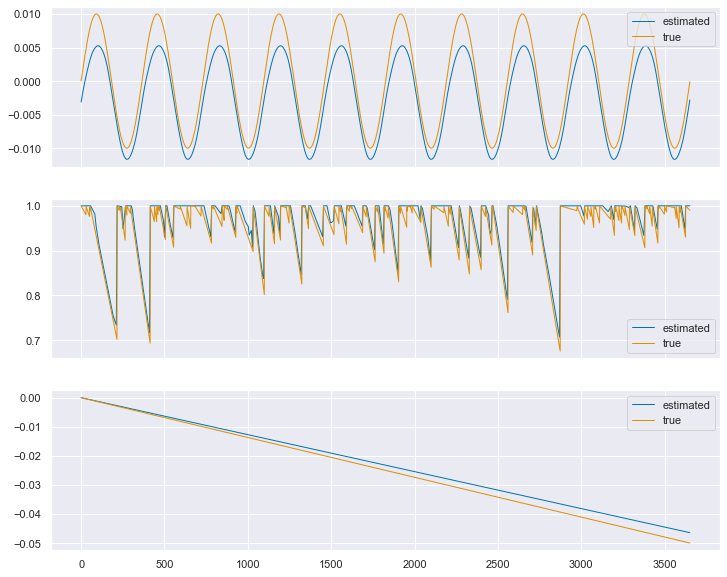

In [8]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(12, 10))
ax[0].plot(s2d - 1, linewidth=1, label='estimated')
ax[0].plot((data.seasonality.values)-1, linewidth=1, label='true')
ax[1].plot(s1d + 1, linewidth=1, label='estimated')
ax[1].plot((data.soiling.values), linewidth=1, label='true')
ax[2].plot(s3d, linewidth=1, label='estimated')
ax[2].plot((data.degradation.values)-1, linewidth=1, label='true')
for i in range(3):
    ax[i].legend()

## Synthetic data example 2

<AxesSubplot:>

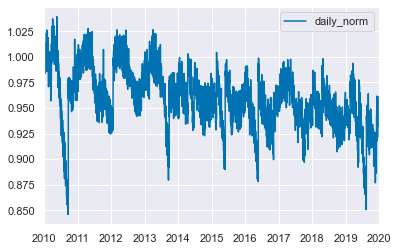

In [9]:
data = dfs[1]
data.plot(y='daily_norm')

In [11]:
soiling_signal = data['daily_norm'].values

config = {
    'degradation_term': True, 
    'tau': 0.85, 
    'iterations': 3, 
    'w1': 0.5, 
    'w2': 8e-2,
    'w3': 1e-2,
    'w4': 1e3
}
ti = time()
s1d, s2d, s3d, srd = soiling_seperation(
    soiling_signal, **config
)
tf = time()
print('that took {:.1f} seconds'.format(tf - ti))

that took 20.3 seconds


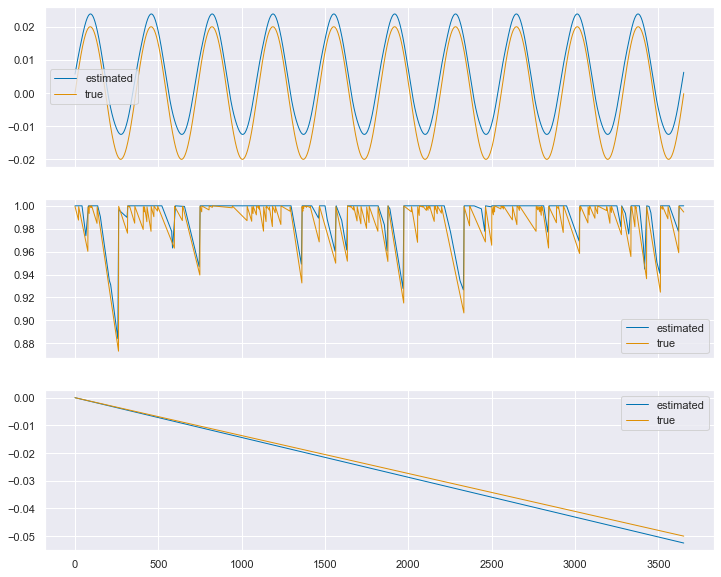

In [12]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(12, 10))
ax[0].plot(s2d-1, linewidth=1, label='estimated')
ax[0].plot((data.seasonality.values)-1, linewidth=1, label='true')
ax[1].plot(s1d+1, linewidth=1, label='estimated')
ax[1].plot((data.soiling.values), linewidth=1, label='true')
ax[2].plot(s3d, linewidth=1, label='estimated')
ax[2].plot((data.degradation.values)-1, linewidth=1, label='true')
for i in range(3):
    ax[i].legend()

## Soiling test data

## Comparison of degradation term estimate to SCSF

In [44]:
dh1.fit_statistical_clear_sky_model()

----------------------
SCSF Problem Setup
----------------------
Matrix Size: 288 x 640 = 184320 power measurements
Sparsity: 69.99%
55313 non-zero measurements under clear conditions
Model size: 288 x 6 + 6 x 640 = 5568 parameters


----------------------
Algorithm Iterations
----------------------
Starting at Objective: 9.688e+07, f1: 5.206e+05, f2: 2.580e+02, f3: 7.976e+07, f4: 1.660e+07
    Minimizing left matrix


/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


    Minimizing right matrix
1 - Objective: 7.524e+05, f1: 6.877e+05, f2: 2.272e+02, f3: 6.446e+04, f4: 2.561e-06
Caution: residuals increased
    Minimizing left matrix
    Minimizing right matrix
2 - Objective: 7.081e+05, f1: 6.425e+05, f2: 4.416e+02, f3: 6.512e+04, f4: 1.301e-07
Caution: residuals increased
    Minimizing left matrix
    Minimizing right matrix
3 - Objective: 7.052e+05, f1: 6.399e+05, f2: 4.464e+02, f3: 6.485e+04, f4: 1.689e-07
Caution: residuals increased
    Minimizing left matrix
    Minimizing right matrix
4 - Objective: 7.046e+05, f1: 6.394e+05, f2: 4.665e+02, f3: 6.467e+04, f4: 2.268e-06
Caution: residuals increased
Minimization complete in 1.41 minutes


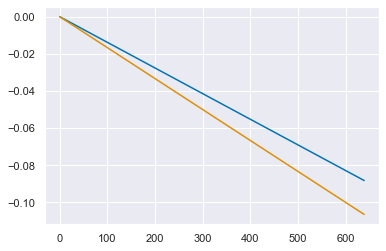

In [45]:
plt.plot(s3e)
plt.plot(dh1.scsf.beta_value * np.linspace(0, len(s3e) / 365, len(s3e)))